# Imports

In [41]:
from lib.lem import *
from lib.draw import *

plt.rcParams['font.family'] = ["Times New Roman"]

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

def cmap(i):
    if i == 1:
        return '#003049'
    else:
        return '#d62828'
    
def add_player_and_team_id(df, data_selected_leagues):
    df['player_id'] = df.index.map(data_selected_leagues[['id', 'player_id']].set_index('id')['player_id'])
    df['player_name'] = df.index.map(data_selected_leagues[['id', 'player_name']].set_index('id')['player_name'])
    df['team_id'] = df.index.map(data_selected_leagues[['id', 'team_id']].set_index('id')['team_id'])
    df['team_name'] = df.index.map(data_selected_leagues[['id', 'team_name']].set_index('id')['team_name'])
    df = df.dropna(subset=['player_id'])

    return df

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 300)

In [42]:
import matplotlib.colors as mcolors
colors = ['white', '#eae2b7', '#fcbf49', '#f77f00', '#d62828', '#003049']
boundaries = [-1, 0.001, 0.10, 0.25, 0.33, 0.5, 1]
thesis_cmap = mcolors.ListedColormap(colors)
thesis_norm = mcolors.BoundaryNorm(boundaries, thesis_cmap.N, clip=True)

# Loading Model

In [43]:
model = MLP(3, [196, 196, 196], 101)
model.load_state_dict(torch.load('models/models/7112_MLP_104961_3_e2.pt', weights_only=True))
model.eval()
model.to(DEVICE);

# Loading Data

In [44]:
data = []
for fname in glob('models/data/tabular_lem/test_extensive_2324_sq3_rs42_*.feather'):
    data.append(pd.read_feather(fname))
data = pd.concat(data, axis=0).astype(int)

In [45]:
competitions = pd.read_csv('data/competitions.csv')
seasons = pd.read_csv('data/seasons.csv')
matches = pd.read_csv('data/matches.csv', low_memory=False)
selected_seasons = seasons[seasons.competition_id.isin(competitions[competitions.area_name.isin(['Portugal']) & (competitions.division_level.isin([1]))].wy_id.tolist()) & (seasons.name.isin(['2023/2024']))]
data_selected_leagues = []
for season in selected_seasons.wy_id.tolist():
    data_selected_leagues.append(pd.read_feather(f'data/seasons/events/{season}.feather'))
data_selected_leagues = pd.concat(data_selected_leagues)
data_selected_leagues = data_selected_leagues.merge(matches[['wy_id', 'home_team_id', 'away_team_id', 'winner']].rename(columns={'wy_id': 'match_id'}), on='match_id')
data_selected_leagues['game_result'] = -1 + (data_selected_leagues.winner == 0) + (data_selected_leagues.winner == data_selected_leagues.team_id) * 2
data_selected_leagues.head(2)

,id,match_id,match_period,minute,second,match_timestamp,video_timestamp,related_event_id,type_primary,x,y,team_id,team_name,team_formation,opponent_team_id,opponent_team_name,opponent_team_formation,player_id,player_name,player_position,pass_accurate,pass_angle,pass_height,pass_length,pass_recipient_id,pass_recipient_name,pass_recipient_position,possession_id,possession_duration,possession_events_number,possession_event_index,possession_start_x,possession_start_y,possession_end_x,possession_end_y,possession_team_id,possession_team_name,possession_team_formation,possession_attack_with_shot,possession_attack_with_shot_on_goal,possession_attack_with_goal,possession_attack_flank,possession_attack_xg,carry_progression,ground_duel_opponent_id,ground_duel_opponent_name,ground_duel_opponent_position,ground_duel_duel_type,ground_duel_kept_possession,ground_duel_progressed_with_ball,ground_duel_stopped_progress,ground_duel_recovered_possession,ground_duel_take_on,ground_duel_side,ground_duel_related_duel_id,aerial_duel_opponent_id,aerial_duel_opponent_name,aerial_duel_opponent_position,aerial_duel_opponent_height,aerial_duel_first_touch,aerial_duel_height,aerial_duel_related_duel_id,infraction_yellow_card,infraction_red_card,infraction_type,infraction_opponent_id,infraction_opponent_name,infraction_opponent_position,shot_body_part,shot_is_goal,shot_on_target,shot_goal_zone,shot_xg,shot_post_shot_xg,shot_goalkeeper_action_id,shot_goalkeeper_id,shot_goalkeeper_name,short_or_medium_pass,ground_duel,forward_pass,lateral_pass,loss,offensive_duel,defensive_duel,recovery,progressive_pass,carry,,back_pass,pass_to_final_third,dribble,aerial_duel,long_pass,ball_out,loose_ball_duel,counterpressing_recovery,pass_to_penalty_area,touch_in_box,head_pass,dribbled_past_attempt,cross,pass,foul,foul_suffered,progressive_run,through_pass,opportunity,deep_completion,shot_assist,deep_completed_cross,smart_pass,hand_pass,linkup_play,sliding_tackle,save,shot_block,free_kick_cross,key_pass,shot_after_corner,save_with_reflex,yellow_card,under_pressure,cross_blocked,whistle,shot_after_free_kick,goal,assist,red_card,head_shot,interception,conceded_goal,possession_attack,possession_set_piece_attack,possession_throw_in,possession_free_kick,possession_transition_low,possession_,possession_transition_medium,possession_corner,possession_free_kick_cross,possession_counterattack,possession_transition_high,end_x,end_y,shot,shot_after_throw_in,third_assist,second_assist,free_kick_shot,penalty_foul,penalty_goal,penalty_conceded_goal,possession_direct_free_kick,possession_penalty,acceleration,penalty_save,home_team_id,away_team_id,winner,game_result
0,2204922500,5490008,1H,0,4,00:00:04.031,5.031036,2.204923e+09,pass,49.0,50.0,9606,Porto,4-4-2,9610,Sporting Braga,4-2-3-1,485406,Evanilson,CF,True,-176.0,None,16.0,698578.0,A. Varela,RCMF,2.204922e+09,28.092889,18.0,0.0,49.0,50.0,49.0,0.0,9606.0,Porto,4-4-2,False,False,False,right,0.0,0.0,0.0,None,None,None,False,False,False,False,False,None,0.0,0.0,None,None,0.0,False,0.0,0.0,False,False,None,0.0,None,None,None,False,False,None,0.0,0.0,0.0,0.0,None,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,34.0,51.0,False,False,False,False,False,False,False,False,False,False,False,False,9610.0,9606.0,9606,1
1,2204922501,5490008,1H,0,6,00:00:06.447,7.447900,2.204923e+09,pass,34.0,51.0,9606,Porto,4-4-2,9610,Sporting Braga,4-2-3-1,698578,A. Varela,RCMF,True,-94.0,None,27.0,40657.0,Wendell,LB,2.204922e+09,28.092889,18.0,1.0,49.0,50.0,49.0,0.0,9606.0,Porto,4-4-2,False,False,False,right,0.0,0.0,0.0,None,None,None,False,False,False,False,False,None,0.0,0.0,None,None,0.0,False,0.0,0.0,False,False,None,0.0,None,Non

# Token-based Apps

## Expected Shots Metric

In [46]:
# Filter relevant events
data_app = data[(data.h != -1) & (data.e == -1)].copy()

# Calculate relevant probabilities
probas = model.predict_proba(data_app.drop(columns=['target']))[:, :RESTRICTIONS['e']][:, 21:24]
data_app['shot_proba'] = probas.sum(axis=1)
data_app['is_shot'] = data_app.target.isin([21, 22, 23])

# Check if the model estimations are reasonable
print(data_app[['shot_proba', 'is_shot']].sum())

# Add player and team ids
data_app = add_player_and_team_id(data_app, data_selected_leagues)

shot_proba    79120.71875
is_shot       76215.00000
dtype: float64


### Evaluate players

In [47]:
data_app.groupby(['player_id', 'player_name', 'team_name'])[['shot_proba', 'is_shot']].sum().sort_values('shot_proba', ascending=False).head(10)

,,,shot_proba,is_shot
player_id,player_name,team_name,,
388986.0,V. Gyökeres,Sporting CP,86.181870,102
594931.0,Francisco Conceicão,Porto,70.698021,76
222676.0,Rafa Silva,Benfica,66.336815,83
3314.0,Á. Di María,Benfica,64.997963,92
363916.0,Pepê Aquino,Porto,62.341385,51
360699.0,Galeno,Porto,56.200798,75
504249.0,Jota Silva,Vitória Guimarães,55.616447,91
521814.0,Pedro Gonçalves,Sporting CP,54.032642,87
70965.0,João Mário,Benfica,54.014046,41


In [48]:
data_app.groupby(['team_id', 'team_name'])[['shot_proba', 'is_shot']].sum().sort_values('shot_proba', ascending=False)

,,shot_proba,is_shot
team_id,team_name,,
9606.0,Porto,617.754089,526
9607.0,Benfica,596.348022,559
9608.0,Sporting CP,546.549927,517
9610.0,Sporting Braga,504.821960,509
9617.0,Vitória Guimarães,415.628265,426
9683.0,Vizela,394.314178,387
9623.0,Estoril,364.600525,373
9789.0,Arouca,356.115479,447
67089.0,Estrela Amadora,352.974457,343


## Pass Risk Metric

In [49]:
# Filter relevant events
data_app = data[(data.t != -1) & (data.a == -1) & (data.e.isin([0, 1, 2]))].copy()

# Calculate relevant probabilities
probas = model.predict_proba(data_app.drop(columns=['target']))[:, :RESTRICTIONS['a']][:, 1]
data_app['accurate_pass_proba'] = probas
data_app['is_accurate_pass'] = data_app.target == 1

# Check if the model estimations are reasonable
print(data_app[['accurate_pass_proba', 'is_accurate_pass']].sum())

# Add player and team ids
data_app = add_player_and_team_id(data_app, data_selected_leagues)

accurate_pass_proba    2160911.5
is_accurate_pass       2242542.0
dtype: float64


### Evaluate players

In [50]:
data_view = data_app.groupby(['player_id', 'player_name', 'team_name'])[['accurate_pass_proba', 'is_accurate_pass']].sum().sort_values('accurate_pass_proba', ascending=False)
data_view['delta'] = data_view.is_accurate_pass - data_view.accurate_pass_proba

In [51]:
data_view.head(10)

,,,accurate_pass_proba,is_accurate_pass,delta
player_id,player_name,team_name,,,
647122.0,Gonçalo Inácio,Sporting CP,1919.785034,2022,102.214966
752489.0,João Neves,Benfica,1549.818970,1688,138.181030
70086.0,N. Otamendi,Benfica,1456.371704,1555,98.628296
471765.0,Javi Montero,Arouca,1439.313354,1474,34.686646
7954.0,S. Coates,Sporting CP,1433.228149,1483,49.771851
807210.0,O. Diomandé,Sporting CP,1425.324707,1513,87.675293
625186.0,Gabriel Pereira,Gil Vicente,1408.374512,1431,22.625488
70767.0,Aderllan Santos,Rio Ave,1408.324463,1445,36.675537
631944.0,António Silva,Benfica,1402.732910,1519,116.267090


In [52]:
data_view.sort_values('delta', ascending=False).head(10)

,,,accurate_pass_proba,is_accurate_pass,delta
player_id,player_name,team_name,,,
752489.0,João Neves,Benfica,1549.818970,1688,138.181030
698578.0,A. Varela,Porto,1326.440430,1446,119.559570
631944.0,António Silva,Benfica,1402.732910,1519,116.267090
70965.0,João Mário,Benfica,1278.908325,1395,116.091675
70093.0,João Moutinho,Sporting Braga,1299.244385,1410,110.755615
647122.0,Gonçalo Inácio,Sporting CP,1919.785034,2022,102.214966
624512.0,Diogo Nascimento,Vizela,1030.381226,1132,101.618774
70086.0,N. Otamendi,Benfica,1456.371704,1555,98.628296
145727.0,F. Aursnes,Benfica,1346.247559,1440,93.752441


In [53]:
data_view[data_view.is_accurate_pass > 100].sort_values('delta', ascending=True).head(10)

,,,accurate_pass_proba,is_accurate_pass,delta
player_id,player_name,team_name,,,
206983.0,J. Cádiz,Famalicão,284.667175,231,-53.667175
723469.0,M. Belloumi,Farense,402.923340,364,-38.923340
339800.0,Cristo González,Arouca,695.542542,662,-33.542542
446458.0,Heriberto Tavares,Estoril,250.732117,218,-32.732117
344011.0,Ronaldo Tavares,Estrela Amadora,145.513794,117,-28.513794
247220.0,Jason,Arouca,570.180481,543,-27.180481
516772.0,Kikas,Estrela Amadora,217.667984,192,-25.667984
437326.0,Bruno Duarte,Farense,332.636383,307,-25.636383
488962.0,Costinha,Rio Ave,779.780518,756,-23.780518


## Accelerators and decelerators

In [54]:
# Filter relevant events
data_app = data[(data.y != -1) & (data.t == -1) & (data.e.isin([0, 1, 2]))].copy()

# Calculate relevant probabilities
probas = model.predict_proba(data_app.drop(columns=['target']))[:, :RESTRICTIONS['t']]
expected_value = (probas * np.arange(RESTRICTIONS['t'])).sum(axis=1)
data_app['expected_time_elapsed'] = expected_value
data_app['time_elapsed'] = data_app.target

# Check if the model estimations are reasonable
print(data_app[['expected_time_elapsed', 'time_elapsed']].mean())

# Add player and team ids
data_app = add_player_and_team_id(data_app, data_selected_leagues)

expected_time_elapsed    3.025722
time_elapsed             3.043910
dtype: float64


### Evaluate players

In [55]:
data_view = data_app.groupby(['player_id', 'player_name', 'team_name'])[['expected_time_elapsed', 'time_elapsed']].sum().sort_values('expected_time_elapsed', ascending=False)
data_view['delta'] = data_view.time_elapsed - data_view.expected_time_elapsed

In [56]:
data_view.sort_values('delta', ascending=True).head(15)

,,,expected_time_elapsed,time_elapsed,delta
player_id,player_name,team_name,,,
523969.0,Zé Carlos,Gil Vicente,2735.026685,2124,-611.026685
611069.0,Gonçalo Franco,Moreirense,3350.022509,2797,-553.022509
222676.0,Rafa Silva,Benfica,2770.714399,2260,-510.714399
343328.0,Tiago Esgaio,Arouca,3299.854266,2806,-493.854266
494557.0,Tomás Händel,Vitória Guimarães,3022.689379,2554,-468.689379
496493.0,Víctor Gómez,Sporting Braga,3402.426061,2936,-466.426061
521814.0,Pedro Gonçalves,Sporting CP,2633.852378,2171,-462.852378
255433.0,Ricardo Horta,Sporting Braga,2725.053772,2292,-433.053772
536573.0,Tomás Silva,Vizela,3380.479308,2989,-391.479308


## Accelerators and decelerators (goalkicks)

In [57]:
# Filter relevant events
data_app = data[(data.y != -1) & (data.t == -1) & (data.e == 16)].copy()

# Calculate relevant probabilities
probas = model.predict_proba(data_app.drop(columns=['target']))[:, :RESTRICTIONS['t']]
expected_value = (probas * np.arange(RESTRICTIONS['t'])).sum(axis=1)
data_app['expected_time_elapsed'] = expected_value
data_app['time_elapsed'] = data_app.target
data_app['is_goal_kick'] = data_app.e == 16

# Check if the model estimations are reasonable
print(data_app[['expected_time_elapsed', 'time_elapsed']].mean())

# Add player and team ids
data_app = add_player_and_team_id(data_app, data_selected_leagues)

expected_time_elapsed    23.589242
time_elapsed             22.560761
dtype: float64


### Evaluate players

In [58]:
data_view = data_app.groupby(['player_id', 'player_name', 'team_name'])[['expected_time_elapsed', 'time_elapsed', 'is_goal_kick']].sum().sort_values('expected_time_elapsed', ascending=False)
data_view['delta'] = data_view.time_elapsed - data_view.expected_time_elapsed

In [59]:
pd.concat([
    data_view.sort_values('delta', ascending=False).head(10),
    data_view.sort_values('delta', ascending=False).tail(10)
])

,,,expected_time_elapsed,time_elapsed,is_goal_kick,delta
player_id,player_name,team_name,,,,
192424.0,Ricardo Batista,Casa Pia AC,6714.923755,7220,284,505.076245
277311.0,F. Buntić,Vizela,5635.039591,6019,236,383.960409
134791.0,Charles,Vitória Guimarães,1377.294983,1570,59,192.705017
490933.0,Rodrigo Moura,Chaves,1313.617322,1505,57,191.382678
532636.0,Goncalo Filipe,Chaves,277.209463,402,12,124.790537
248846.0,M. Villanueva,Vitória Guimarães,39.983879,158,2,118.016121
3296.0,Antonio Adán,Sporting CP,2407.089473,2498,102,90.910527
71991.0,Cláudio Ramos,Porto,70.210330,161,3,90.789670
254896.0,Thiago,Arouca,300.221046,384,13,83.778954


# Simulation-based Apps

## Token Probability Trees

In [60]:
N_SIMS = 2000
selected_event = data[data.h == -1].drop('target', axis=1).iloc[5]

In [61]:
game_tensor = torch.Tensor(selected_event.values)
game_tensor = game_tensor.repeat(N_SIMS, 1).to(DEVICE)

pred = simulate_event(model, game_tensor)
pred = pd.DataFrame(pred.cpu().numpy(), columns=['h', 'e', 'x', 'y', 't', 'a'])
pred.e = TOKENIZER.decode_event_types(pred.e)
pred.head()

,h,e,x,y,t,a
0,1.0,pass,44.0,46.0,5.0,1.0
1,1.0,pass,66.0,74.0,1.0,1.0
2,1.0,pass,65.0,73.0,2.0,1.0
3,1.0,long_pass,57.0,50.0,5.0,1.0
4,1.0,pass,31.0,66.0,1.0,1.0


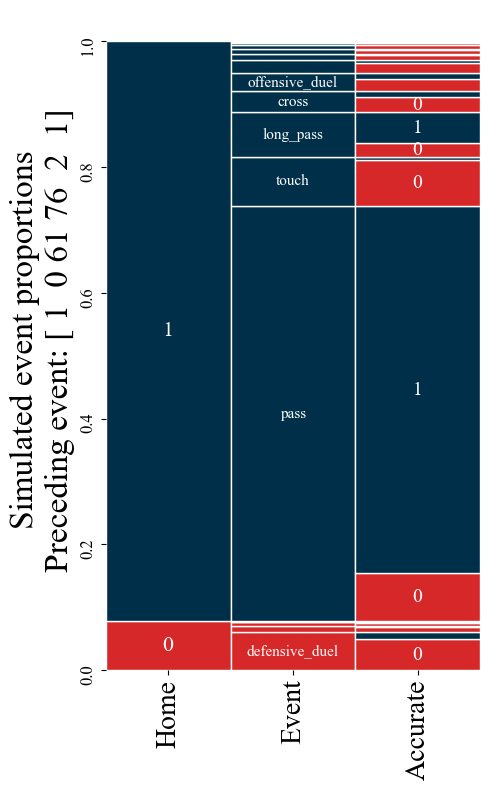

In [71]:
MIN_HEIGHT_FOR_TEXT = 0.02
plt.rcParams['figure.figsize'] = (5, 8)
vc0 = pred.h.value_counts().sort_index() / pred.shape[0]
prev_bottom0 = 0
for i, value0 in vc0.items():
    plt.bar(0, value0, bottom=prev_bottom0, color=cmap(i), edgecolor=f'white', width=1)
    plt.text(0, prev_bottom0 + value0 / 2, f'{int(i)}', ha='center', va='center', color='white', fontsize=16)

    vc1 = pred[pred.h == i].e.value_counts() / pred[pred.h == i].shape[0]
    prev_bottom1 = prev_bottom0
    for j, value1 in vc1.items():
        plt.bar(1, value1 * value0, bottom=prev_bottom1, color=cmap(i), edgecolor=f'white', width=1)
        if value1 * value0 > MIN_HEIGHT_FOR_TEXT:
            plt.text(1, prev_bottom1 + value1 * value0 / 2, f'{j}', ha='center', va='center', color='white', fontsize=11)

        vc2 = pred[(pred.h == i) & (pred.e == j)].a.value_counts().sort_index() / pred[(pred.h == i) & (pred.e == j)].shape[0]
        prev_bottom2 = prev_bottom1
        for k, value2 in vc2.items():
            plt.bar(2, value2 * value1 * value0, bottom=prev_bottom2, color=cmap(k), edgecolor=f'white', width=1)
            if value2 * value1 * value0 > MIN_HEIGHT_FOR_TEXT:
                plt.text(2, prev_bottom2 + value2 * value1 * value0 / 2, f'{int(k)}', ha='center', va='center', color='white', fontsize=14)

            prev_bottom2 += value2 * value1 * value0
        prev_bottom1 += value1 * value0
    prev_bottom0 += value0

plt.ylabel(f'Simulated event proportions\n'+f'Preceding event: {data[['c1_h', 'c1_e', 'c1_x', 'c1_y', 'c1_t', 'c1_a']][data.h == -1].iloc[5].values}', fontsize=24)
# plt.ylabel('Proportion', fontsize=24)
plt.xticks([0, 1, 2], ['Home', 'Event', 'Accurate'], fontsize=20, rotation=90)
plt.yticks(fontsize=12, rotation=90)
plt.xlim(-0.5, 2.5)
plt.box(False)
plt.tight_layout()
plt.savefig('output/phd/7210_simulated_event_tree_unfolding.pdf', bbox_inches='tight')

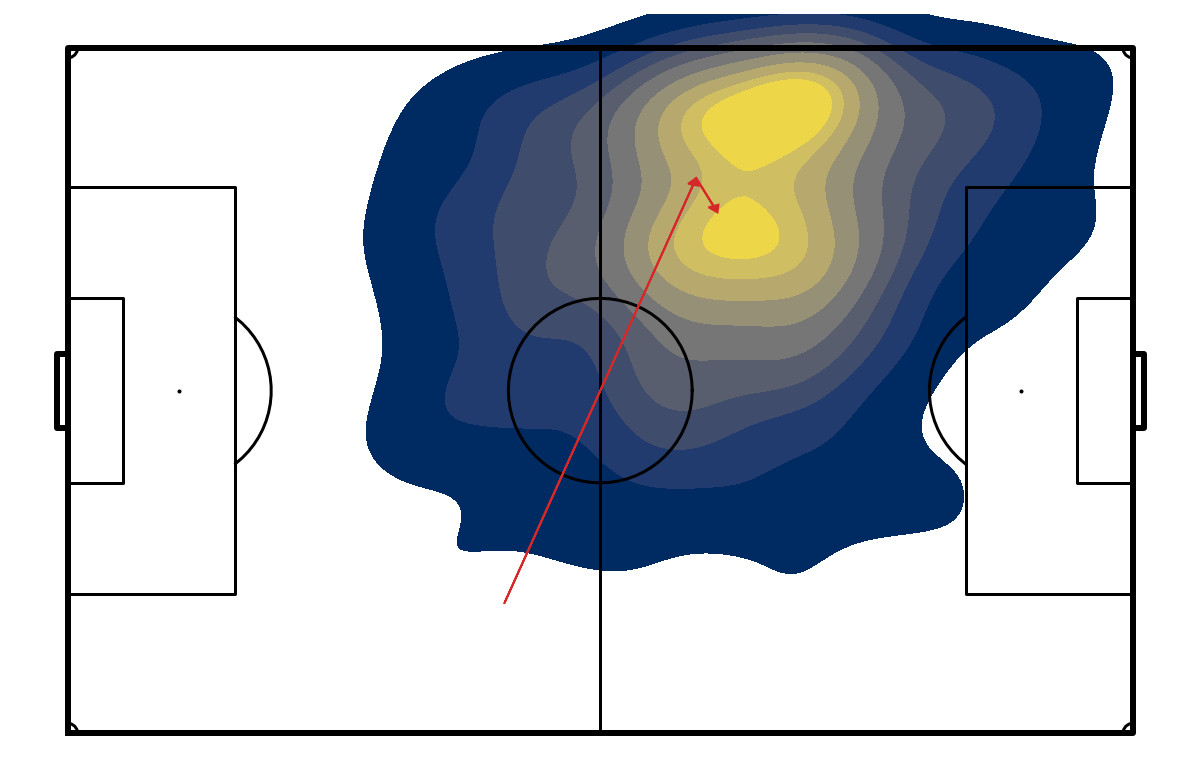

In [23]:
pitch()

# inverting coords for away team
pred['x'] = np.where(pred.h == 0, 100 - pred.x, pred.x)
pred['y'] = np.where(pred.h == 0, 100 - pred.y, pred.y)

cmap_viz = plt.get_cmap('cividis')
plt.arrow(selected_event.c3_x, selected_event.c3_y, selected_event.c2_x - selected_event.c3_x, selected_event.c2_y - selected_event.c3_y, color='#d62828', head_width=1, head_length=1, zorder=10, length_includes_head=True)
plt.arrow(selected_event.c2_x, selected_event.c2_y, selected_event.c1_x - selected_event.c2_x, selected_event.c1_y - selected_event.c2_y, color='#d62828', head_width=1, head_length=1, zorder=10, length_includes_head=True)

# ax = plt.gca()
# axins = inset_axes(ax, width = "2.5%", height = "80%", loc = 'center left',
#                    bbox_to_anchor = (0.98, 0., 1, 1), bbox_transform = ax.transAxes,
#                    borderpad = 0)
# cb = plt.colorbar(cax=axins);
# cb.set_label('Density', fontsize=16)
# plot kde map of x, y from pred
sns.kdeplot(data=pred, x='x', y='y', fill=True, cmap='cividis', levels=10, thresh=0.05);
plt.savefig('output/phd/7210_simulated_event.pdf', bbox_inches='tight')

### Location in k events

In [24]:
game_tensor = torch.Tensor(selected_event.values)
game_tensor = game_tensor.repeat(N_SIMS, 1).to(DEVICE)

pred = simulate_game(model, game_tensor, max_sims=10, return_type='state')
pred = pd.DataFrame(pred, columns=['h', 'e', 'x', 'y', 't', 'a'])
pred.e = TOKENIZER.decode_event_types(pred.e)
pred.head()

100%|██████████| 10/10 [00:00<00:00, 28.83it/s]


,h,e,x,y,t,a
0,0.0,pass,78.0,31.0,2.0,1.0
1,1.0,pass,37.0,10.0,1.0,1.0
2,1.0,interception,2.0,62.0,1.0,0.0
3,0.0,carry,30.0,10.0,0.0,0.0
4,0.0,dribble,44.0,45.0,1.0,0.0


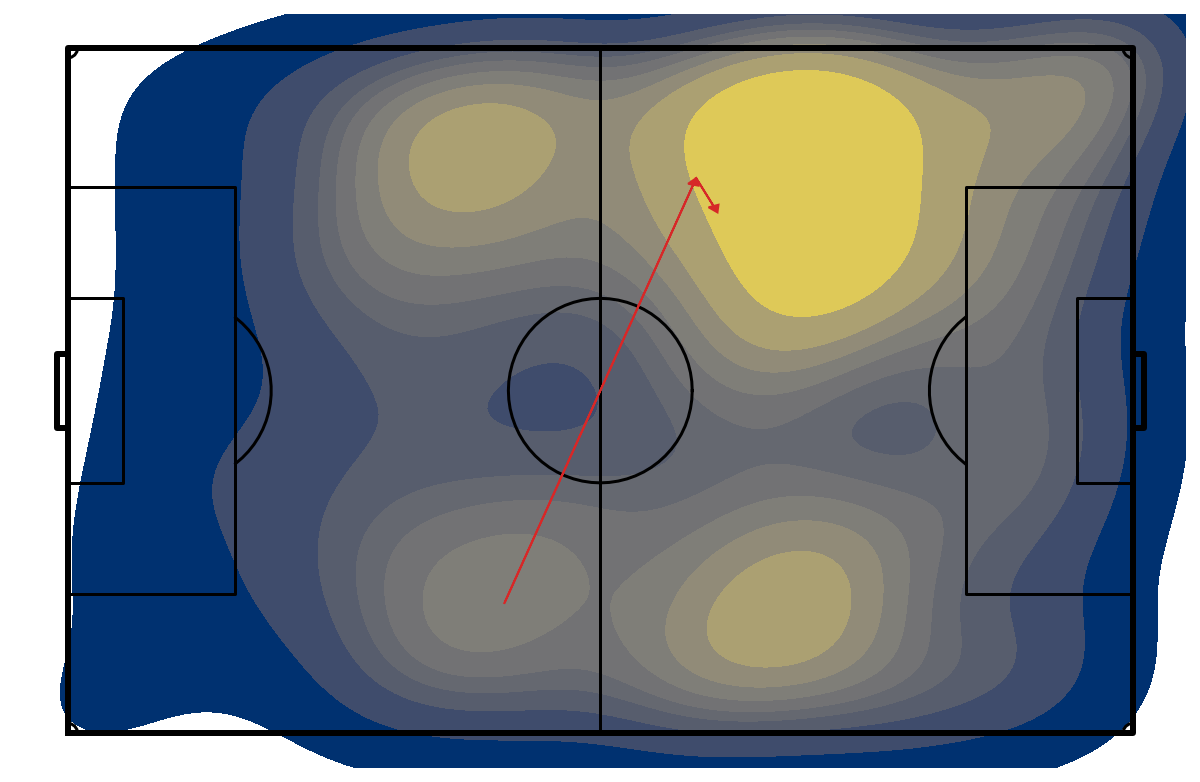

In [25]:
pitch()

# inverting coords for away team
pred['x'] = np.where(pred.h == 0, 100 - pred.x, pred.x)
pred['y'] = np.where(pred.h == 0, 100 - pred.y, pred.y)

cmap_viz = plt.get_cmap('cividis')
plt.arrow(selected_event.c3_x, selected_event.c3_y, selected_event.c2_x - selected_event.c3_x, selected_event.c2_y - selected_event.c3_y, color='#d62828', head_width=1, head_length=1, zorder=10, length_includes_head=True)
plt.arrow(selected_event.c2_x, selected_event.c2_y, selected_event.c1_x - selected_event.c2_x, selected_event.c1_y - selected_event.c2_y, color='#d62828', head_width=1, head_length=1, zorder=10, length_includes_head=True)

# plot kde map of x, y from pred
sns.kdeplot(data=pred, x='x', y='y', fill=True, cmap='cividis', levels=10, thresh=0.05);
plt.savefig('output/phd/7210_simulated_event_k10.pdf', bbox_inches='tight')

## Short Term Probabilities

In [26]:
data_selected_game = data_selected_leagues[data_selected_leagues.match_id == 5489917]
data_selected_game = data.loc[data_selected_game.id]
data_selected_game = data_selected_game[data_selected_game.h == -1].sort_index().sort_values(['p', 'm', 's']).astype(int)
data_selected_game.head(6)

,h,e,x,y,t,a,p,m,s,hg,ag,hr,ar,hy,ay,c1_h,c1_e,c1_x,c1_y,c1_t,c1_a,c2_h,c2_e,c2_x,c2_y,c2_t,c2_a,c3_h,c3_e,c3_x,c3_y,c3_t,c3_a,target
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2109784258,-1,-1,-1,-1,-1,-1,0,0,0,0,0,0,0,0,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1
2109784259,-1,-1,-1,-1,-1,-1,0,0,6,0,0,0,0,0,0,1,0,49,51,0,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1
2109784260,-1,-1,-1,-1,-1,-1,0,0,7,0,0,0,0,0,0,1,0,43,59,1,1,1,0,49,51,0,1,-1,-1,-1,-1,-1,-1,1
2109784261,-1,-1,-1,-1,-1,-1,0,0,9,0,0,0,0,0,0,1,0,39,36,2,1,1,0,43,59,1,1,1,0,49,51,0,1,1
2109784262,-1,-1,-1,-1,-1,-1,0,0,11,0,0,0,0,0,0,1,0,26,40,2,1,1,0,39,36,2,1,1,0,43,59,1,1,1
2109784312,-1,-1,-1,-1,-1,-1,0,0,14,0,0,0,0,0,0,1,1,25,9,3,1,1,0,26,40,2,1,1,0,39,36,2,1,0


In [27]:
N_SIMS = 2500
short_term_scoring_count_home, short_term_scoring_count_away = [], []

for i, row in tqdm(data_selected_game.iterrows(), total=data_selected_game.shape[0]):
    game_tensor = torch.Tensor(row.values[:-1])
    game_tensor = game_tensor.repeat(N_SIMS, 1).to(DEVICE)

    gd, hg, ag, n = simulate_game(model, game_tensor, max_sims=10, return_unfinished=True, tqdm_disable=True)
    short_term_scoring_count_home.append((hg > row.hg).sum() / N_SIMS)
    short_term_scoring_count_away.append((ag > row.ag).sum() / N_SIMS)

100%|██████████| 1835/1835 [02:34<00:00, 11.91it/s]


In [28]:
data_selected_game['short_term_scoring_count_home'] = short_term_scoring_count_home
data_selected_game['short_term_scoring_count_away'] = short_term_scoring_count_away

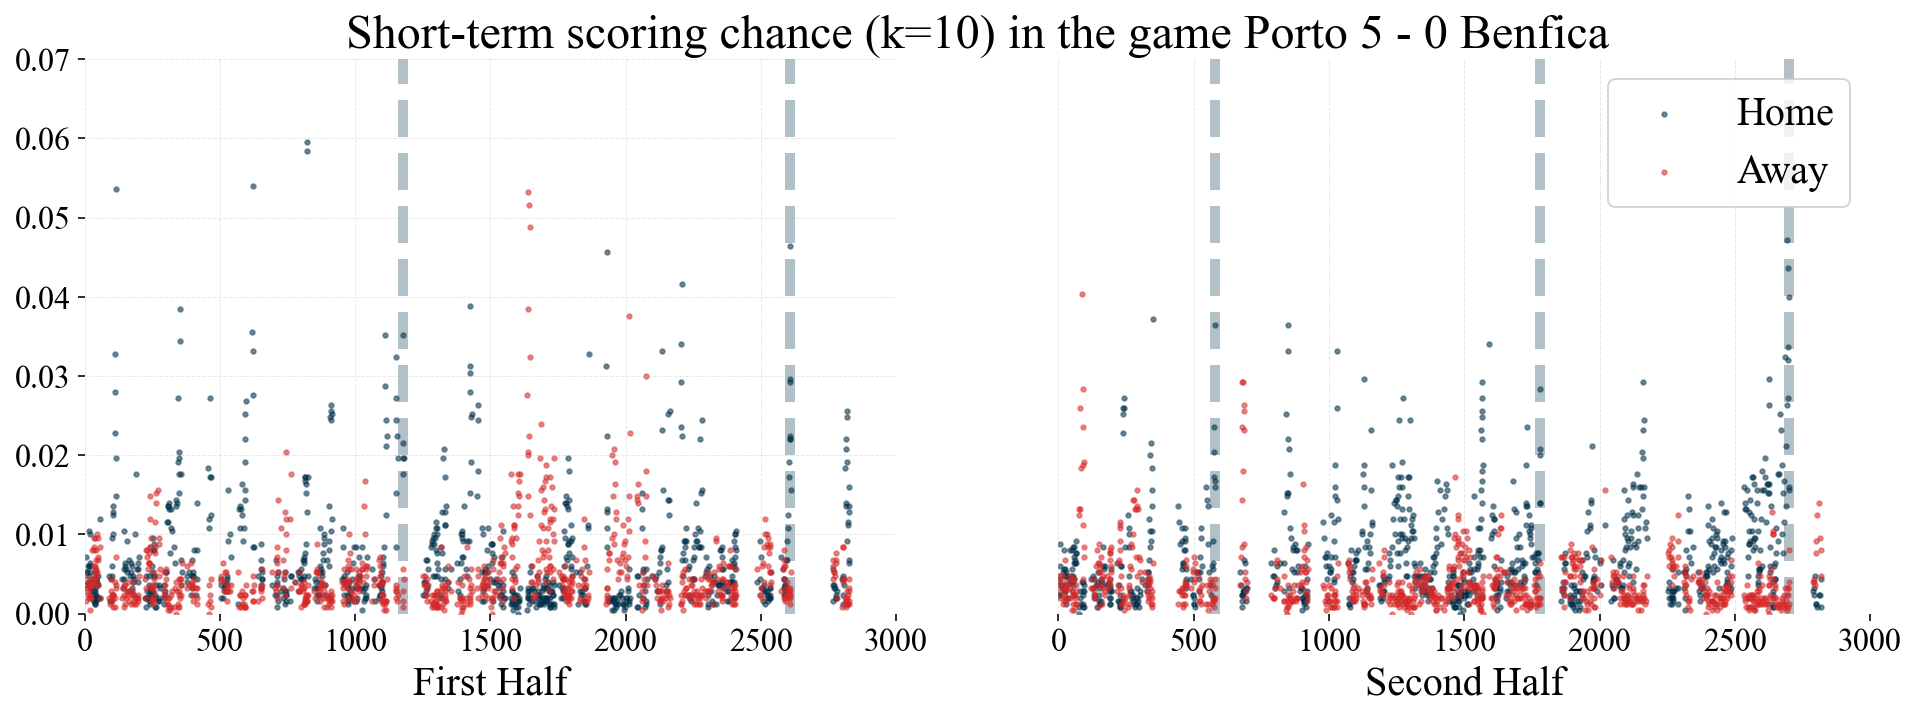

In [29]:
plt.rcParams['figure.figsize'] = (16, 5)
plt.title('Short-term scoring chance (k=10) in the game Porto 5 - 0 Benfica', fontsize=24)
plt.box(False)
plt.xticks([])
plt.yticks([])

goals = data_selected_game[data_selected_game.c1_e.isin([21, 22, 23]) & (data_selected_game.c1_a == 1)]

plt.subplot(121)
data_plot = data_selected_game[data_selected_game.p == 0]
plt.scatter(data_plot.m * 60 + data_plot.s, data_plot.short_term_scoring_count_home, s=5, label='Home', color='#003049', alpha=0.5)
plt.scatter(data_plot.m * 60 + data_plot.s, data_plot.short_term_scoring_count_away, s=5, label='Away', color='#d62828', alpha=0.5)
plt.xlabel('First Half', fontsize=20)
plt.xlim(0, 50 * 60)
for i, goal in goals[goals.p == 0].iterrows():
    plt.axvline(goal.m * 60 + goal.s, color='#003049', linestyle='--', lw=5, alpha=0.3, zorder=-1)
plt.ylim(0, 0.07)
plt.box(False)
plt.grid(True, which='both', axis='both', linestyle='--', linewidth=0.5, alpha=0.3)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)

plt.subplot(122)
data_plot = data_selected_game[data_selected_game.p == 1]
plt.scatter((data_plot.m - 45) * 60 + data_plot.s, data_plot.short_term_scoring_count_home, s=5, label='Home', color='#003049', alpha=0.5)
plt.scatter((data_plot.m - 45) * 60 + data_plot.s, data_plot.short_term_scoring_count_away, s=5, label='Away', color='#d62828', alpha=0.5)
plt.xlabel('Second Half', fontsize=20)
plt.xlim(0, 50 * 60)
for i, goal in goals[goals.p == 1].iterrows():
    plt.axvline((goal.m - 45) * 60 + goal.s, color='#003049', linestyle='--', lw=5, alpha=0.3, zorder=-1)
plt.ylim(0, 0.07)
plt.grid(True, which='both', axis='both', linestyle='--', linewidth=0.5, alpha=0.3)
plt.yticks([])
plt.box(False)
plt.xticks(fontsize=16)

plt.legend(fontsize=20);
plt.savefig('output/phd/7210_short_term_scoring_chance.pdf', bbox_inches='tight')

## Long Term Probabilities

### Porto 5 - 0 Benfica

In [30]:
data_selected_game = data_selected_leagues[data_selected_leagues.match_id == 5489917]
data_selected_game = data.loc[data_selected_game.id]
data_selected_game = data_selected_game[data_selected_game.h == -1].sort_index().sort_values(['p', 'm', 's']).astype(int)

In [31]:
N_SIMS = 1000
long_term_probabilities = []

chunk_size = 25
for chunk_start in tqdm(range(0, data_selected_game.shape[0], chunk_size)):
    chunk_end = min(chunk_start + chunk_size, data_selected_game.shape[0])
    chunk = data_selected_game.iloc[chunk_start:chunk_end]

    game_tensor = torch.Tensor(chunk.values[:, :-1])
    game_tensor = game_tensor.repeat(N_SIMS, 1).to(DEVICE)

    gd, hg, ag, n = simulate_game(model, game_tensor, max_sims=2500, return_unfinished=True, tqdm_disable=True)

    aranged = np.arange(hg.size)
    for i in range(min(chunk_size, chunk.shape[0])):
        long_term_probabilities.append((
            (gd[(aranged % min(chunk_size, chunk.shape[0])) == i] > 0).sum() / N_SIMS,
            (gd[(aranged % min(chunk_size, chunk.shape[0])) == i] == 0).sum() / N_SIMS,
            (gd[(aranged % min(chunk_size, chunk.shape[0])) == i] < 0).sum() / N_SIMS
        ))
data_selected_game['long_term_home_win_probability'] = [x[0] for x in long_term_probabilities]
data_selected_game['long_term_draw_probability'] = [x[1] for x in long_term_probabilities]
data_selected_game['long_term_away_win_probability'] = [x[2] for x in long_term_probabilities]

100%|██████████| 74/74 [25:05<00:00, 20.34s/it]


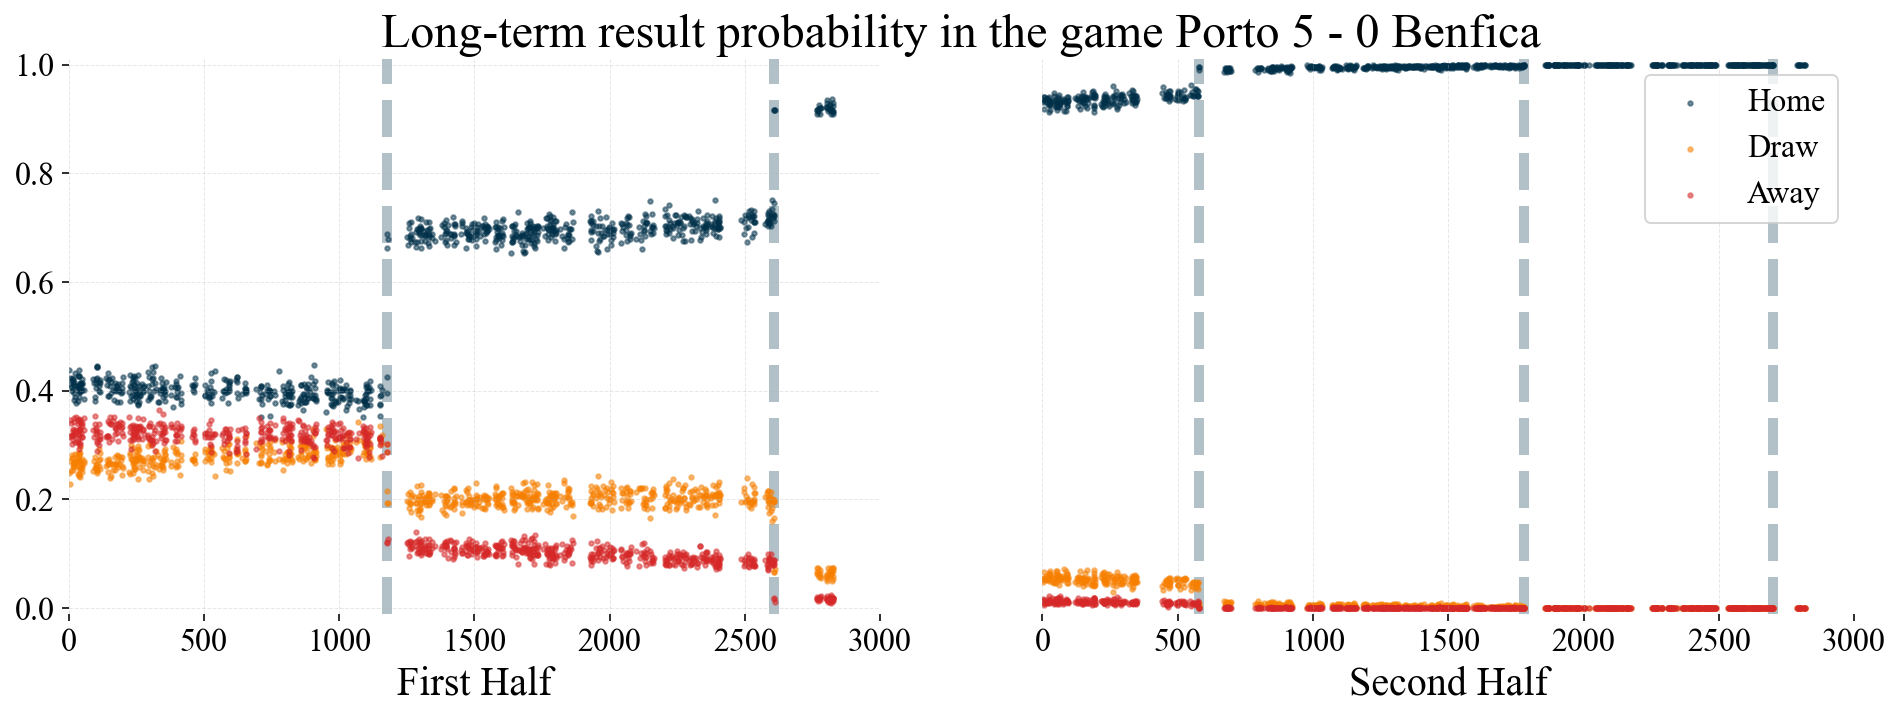

In [32]:
plt.rcParams['figure.figsize'] = (16, 5)
plt.title('Long-term result probability in the game Porto 5 - 0 Benfica', fontsize=24)
plt.box(False)
plt.xticks([])
plt.yticks([])

goals = data_selected_game[data_selected_game.c1_e.isin([21, 22, 23]) & (data_selected_game.c1_a == 1)]

plt.subplot(121)
data_plot = data_selected_game[data_selected_game.p == 0]
plt.scatter(data_plot.m * 60 + data_plot.s, data_plot.long_term_home_win_probability, s=5, label='Home', color='#003049', alpha=0.5)
plt.scatter(data_plot.m * 60 + data_plot.s, data_plot.long_term_draw_probability, s=5, label='Draw', color='#f77f00', alpha=0.5)
plt.scatter(data_plot.m * 60 + data_plot.s, data_plot.long_term_away_win_probability, s=5, label='Away', color='#d62828', alpha=0.5)
plt.xlabel('First Half', fontsize=20)
plt.xlim(0, 50 * 60)
for i, goal in goals[goals.p == 0].iterrows():
    if goal.c1_h == 0:
        plt.axvline(goal.m * 60 + goal.s, color='#d62828', linestyle='--', lw=5, alpha=0.3, zorder=-1)
    else:
        plt.axvline(goal.m * 60 + goal.s, color='#003049', linestyle='--', lw=5, alpha=0.3, zorder=-1)
plt.ylim(-0.01, 1.01)
plt.box(False)
plt.grid(True, which='both', axis='both', linestyle='--', linewidth=0.5, alpha=0.3)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.legend(fontsize=16, loc='upper left');

plt.subplot(122)
data_plot = data_selected_game[data_selected_game.p == 1]
plt.scatter((data_plot.m - 45) * 60 + data_plot.s, data_plot.long_term_home_win_probability, s=5, label='Home', color='#003049', alpha=0.5)
plt.scatter((data_plot.m - 45) * 60 + data_plot.s, data_plot.long_term_draw_probability, s=5, label='Draw', color='#f77f00', alpha=0.5)
plt.scatter((data_plot.m - 45) * 60 + data_plot.s, data_plot.long_term_away_win_probability, s=5, label='Away', color='#d62828', alpha=0.5)
plt.xlabel('Second Half', fontsize=20)
plt.xlim(0, 50 * 60)
for i, goal in goals[goals.p == 1].iterrows():
    if goal.c1_h == 0:
        plt.axvline((goal.m- 45) * 60 + goal.s, color='#d62828', linestyle='--', lw=5, alpha=0.3, zorder=-1)
    else:
        plt.axvline((goal.m- 45) * 60 + goal.s, color='#003049', linestyle='--', lw=5, alpha=0.3, zorder=-1)
plt.ylim(-0.01, 1.01)
plt.grid(True, which='both', axis='both', linestyle='--', linewidth=0.5, alpha=0.3)
plt.yticks([])
plt.box(False)
plt.xticks(fontsize=16)

plt.savefig('output/phd/7210_long_term_probabilities_porto_benfica.pdf', bbox_inches='tight');

### Porto 2 - 2 Sporting

In [33]:
data_selected_game = data_selected_leagues[data_selected_leagues.match_id == 5489973]
data_selected_game = data.loc[data_selected_game.id]
data_selected_game = data_selected_game[data_selected_game.h == -1].sort_index().sort_values(['p', 'm', 's']).astype(int)

In [34]:
N_SIMS = 1000
long_term_probabilities = []

chunk_size = 25
for chunk_start in tqdm(range(0, data_selected_game.shape[0], chunk_size)):
    chunk_end = min(chunk_start + chunk_size, data_selected_game.shape[0])
    chunk = data_selected_game.iloc[chunk_start:chunk_end]

    game_tensor = torch.Tensor(chunk.values[:, :-1])
    game_tensor = game_tensor.repeat(N_SIMS, 1).to(DEVICE)

    gd, hg, ag, n = simulate_game(model, game_tensor, max_sims=2500, return_unfinished=True, tqdm_disable=True)

    aranged = np.arange(hg.size)
    for i in range(min(chunk_size, chunk.shape[0])):
        long_term_probabilities.append((
            (gd[(aranged % min(chunk_size, chunk.shape[0])) == i] > 0).sum() / N_SIMS,
            (gd[(aranged % min(chunk_size, chunk.shape[0])) == i] == 0).sum() / N_SIMS,
            (gd[(aranged % min(chunk_size, chunk.shape[0])) == i] < 0).sum() / N_SIMS
        ))
data_selected_game['long_term_home_win_probability'] = [x[0] for x in long_term_probabilities]
data_selected_game['long_term_draw_probability'] = [x[1] for x in long_term_probabilities]
data_selected_game['long_term_away_win_probability'] = [x[2] for x in long_term_probabilities]

100%|██████████| 69/69 [23:20<00:00, 20.30s/it]


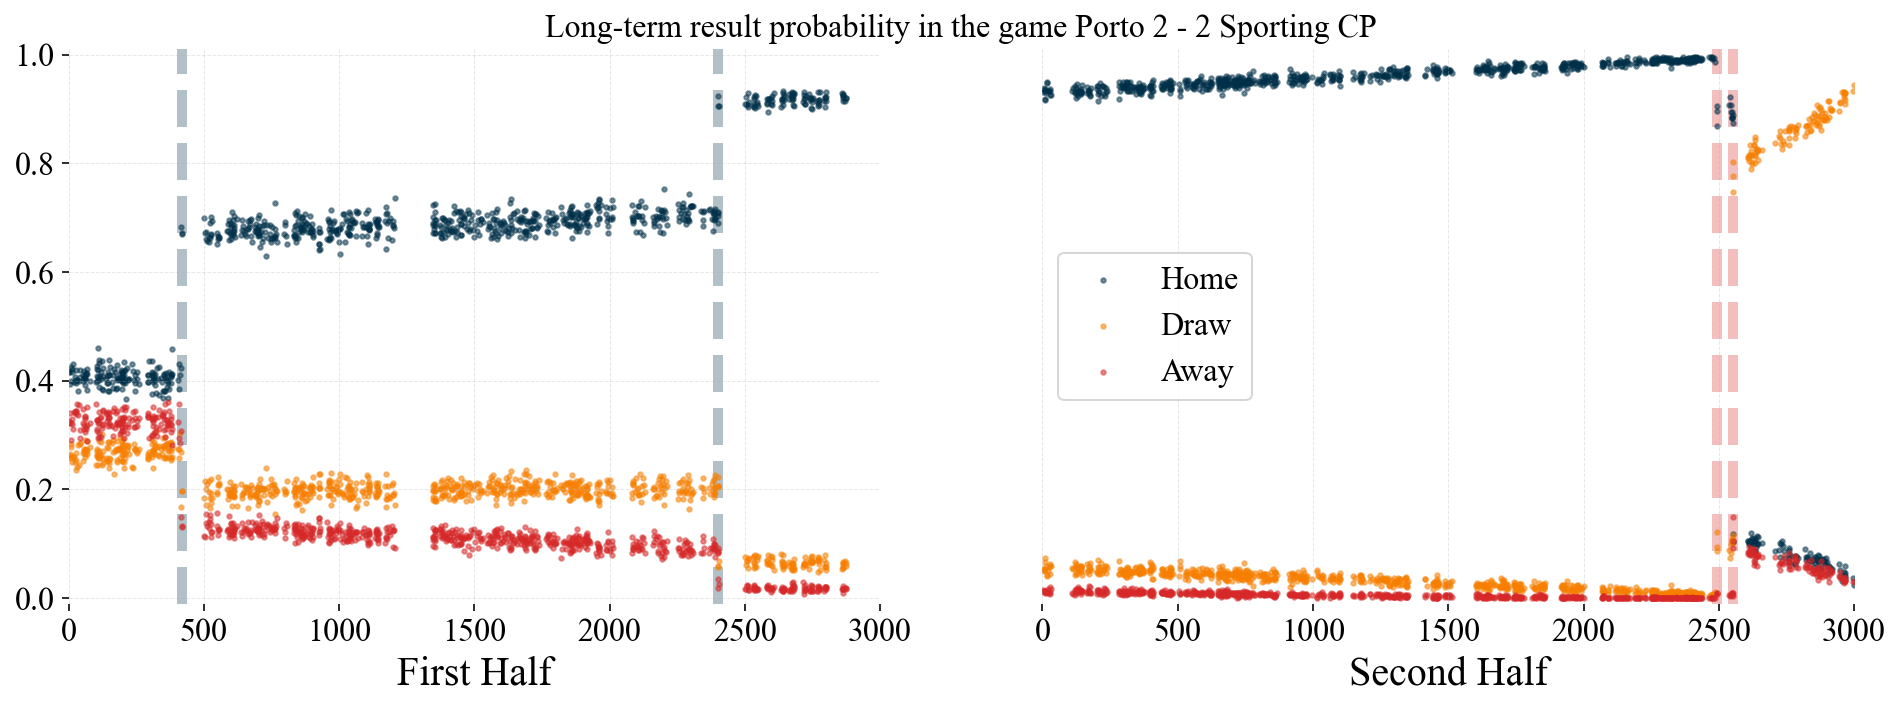

In [35]:
plt.rcParams['figure.figsize'] = (16, 5)
plt.title('Long-term result probability in the game Porto 2 - 2 Sporting CP', fontsize=16)
plt.box(False)
plt.xticks([])
plt.yticks([])

goals = data_selected_game[data_selected_game.c1_e.isin([21, 22, 23]) & (data_selected_game.c1_a == 1)]

plt.subplot(121)
data_plot = data_selected_game[data_selected_game.p == 0]
plt.scatter(data_plot.m * 60 + data_plot.s, data_plot.long_term_home_win_probability, s=5, label='Home', color='#003049', alpha=0.5)
plt.scatter(data_plot.m * 60 + data_plot.s, data_plot.long_term_draw_probability, s=5, label='Draw', color='#f77f00', alpha=0.5)
plt.scatter(data_plot.m * 60 + data_plot.s, data_plot.long_term_away_win_probability, s=5, label='Away', color='#d62828', alpha=0.5)
plt.xlabel('First Half', fontsize=20)
plt.xlim(0, 50 * 60)
for i, goal in goals[goals.p == 0].iterrows():
    if goal.c1_h == 0:
        plt.axvline(goal.m * 60 + goal.s, color='#d62828', linestyle='--', lw=5, alpha=0.3, zorder=-1)
    else:
        plt.axvline(goal.m * 60 + goal.s, color='#003049', linestyle='--', lw=5, alpha=0.3, zorder=-1)
plt.ylim(-0.01, 1.01)
plt.box(False)
plt.grid(True, which='both', axis='both', linestyle='--', linewidth=0.5, alpha=0.3)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.legend(fontsize=16, loc='upper left');

plt.subplot(122)
data_plot = data_selected_game[data_selected_game.p == 1]
plt.scatter((data_plot.m - 45) * 60 + data_plot.s, data_plot.long_term_home_win_probability, s=5, label='Home', color='#003049', alpha=0.5)
plt.scatter((data_plot.m - 45) * 60 + data_plot.s, data_plot.long_term_draw_probability, s=5, label='Draw', color='#f77f00', alpha=0.5)
plt.scatter((data_plot.m - 45) * 60 + data_plot.s, data_plot.long_term_away_win_probability, s=5, label='Away', color='#d62828', alpha=0.5)
plt.xlabel('Second Half', fontsize=20)
plt.xlim(0, 50 * 60)
for i, goal in goals[goals.p == 1].iterrows():
    if goal.c1_h == 0:
        plt.axvline((goal.m- 45) * 60 + goal.s, color='#d62828', linestyle='--', lw=5, alpha=0.3, zorder=-1)
    else:
        plt.axvline((goal.m- 45) * 60 + goal.s, color='#003049', linestyle='--', lw=5, alpha=0.3, zorder=-1)
plt.ylim(-0.01, 1.01)
plt.grid(True, which='both', axis='both', linestyle='--', linewidth=0.5, alpha=0.3)
plt.yticks([])
plt.box(False)
plt.xticks(fontsize=16)

plt.savefig('output/phd/7210_long_term_probabilities_porto_sporting.pdf', bbox_inches='tight');

### Vitória Guimarães 2 - 3 Sporting Braga

In [36]:
data_selected_game = data_selected_leagues[data_selected_leagues.match_id == 5489998]
data_selected_game = data.loc[data_selected_game.id]
data_selected_game = data_selected_game[data_selected_game.h == -1].sort_index().sort_values(['p', 'm', 's']).astype(int)

In [37]:
N_SIMS = 1000
long_term_probabilities = []

chunk_size = 25
for chunk_start in tqdm(range(0, data_selected_game.shape[0], chunk_size)):
    chunk_end = min(chunk_start + chunk_size, data_selected_game.shape[0])
    chunk = data_selected_game.iloc[chunk_start:chunk_end]

    game_tensor = torch.Tensor(chunk.values[:, :-1])
    game_tensor = game_tensor.repeat(N_SIMS, 1).to(DEVICE)

    gd, hg, ag, n = simulate_game(model, game_tensor, max_sims=2500, return_unfinished=True, tqdm_disable=True)

    aranged = np.arange(hg.size)
    for i in range(min(chunk_size, chunk.shape[0])):
        long_term_probabilities.append((
            (gd[(aranged % min(chunk_size, chunk.shape[0])) == i] > 0).sum() / N_SIMS,
            (gd[(aranged % min(chunk_size, chunk.shape[0])) == i] == 0).sum() / N_SIMS,
            (gd[(aranged % min(chunk_size, chunk.shape[0])) == i] < 0).sum() / N_SIMS
        ))
data_selected_game['long_term_home_win_probability'] = [x[0] for x in long_term_probabilities]
data_selected_game['long_term_draw_probability'] = [x[1] for x in long_term_probabilities]
data_selected_game['long_term_away_win_probability'] = [x[2] for x in long_term_probabilities]

100%|██████████| 66/66 [22:05<00:00, 20.08s/it]


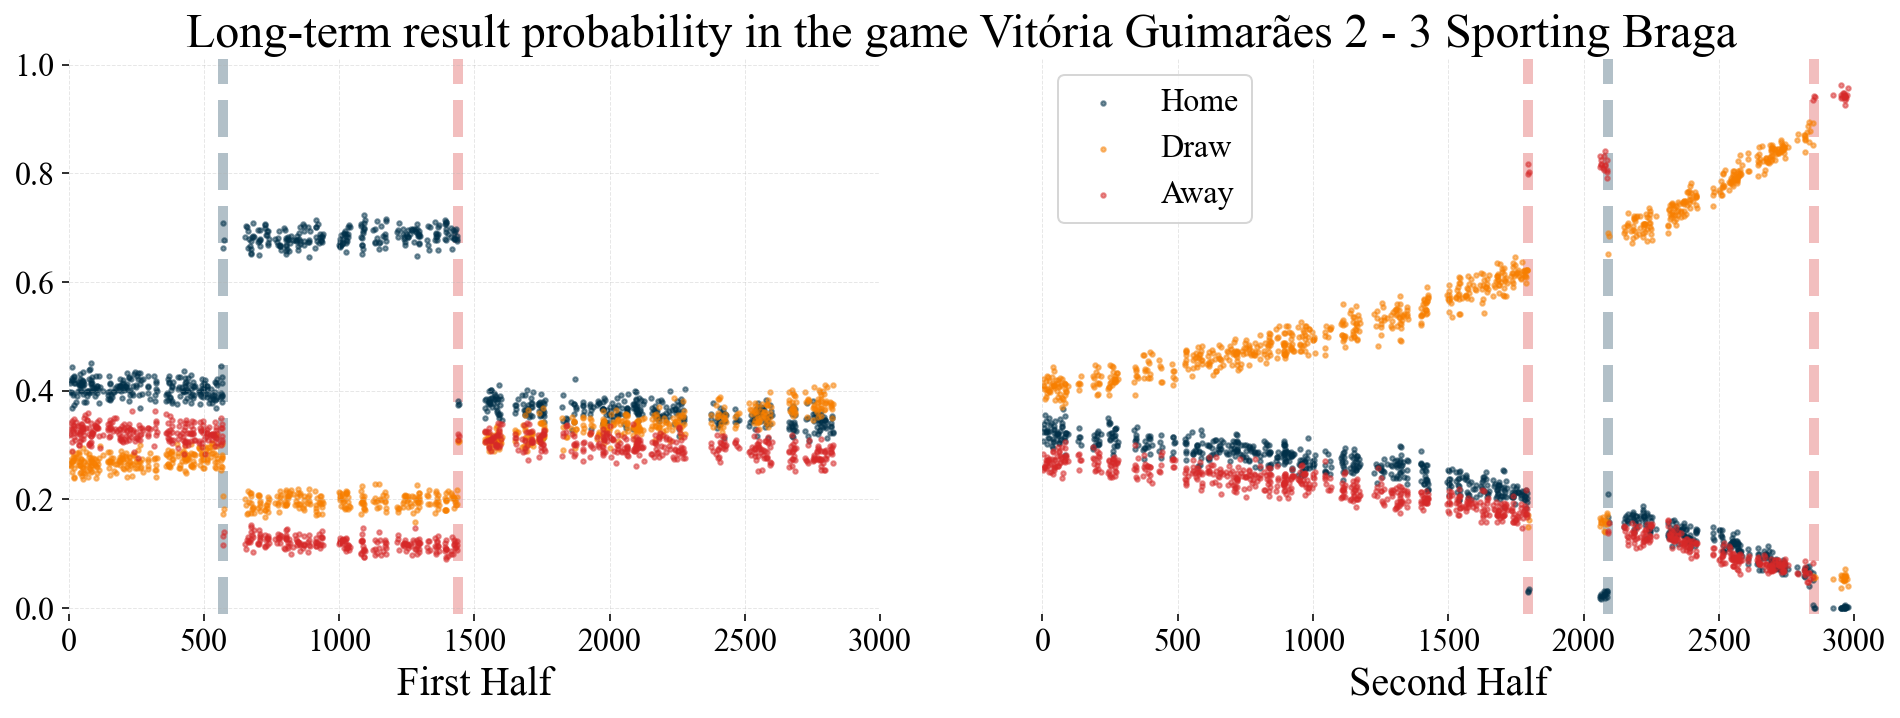

In [38]:
plt.rcParams['figure.figsize'] = (16, 5)
plt.title('Long-term result probability in the game Vitória Guimarães 2 - 3 Sporting Braga', fontsize=24)
plt.box(False)
plt.xticks([])
plt.yticks([])

goals = data_selected_game[data_selected_game.c1_e.isin([21, 22, 23]) & (data_selected_game.c1_a == 1)]

plt.subplot(121)
data_plot = data_selected_game[data_selected_game.p == 0]
plt.scatter(data_plot.m * 60 + data_plot.s, data_plot.long_term_home_win_probability, s=5, label='Home', color='#003049', alpha=0.5)
plt.scatter(data_plot.m * 60 + data_plot.s, data_plot.long_term_draw_probability, s=5, label='Draw', color='#f77f00', alpha=0.5)
plt.scatter(data_plot.m * 60 + data_plot.s, data_plot.long_term_away_win_probability, s=5, label='Away', color='#d62828', alpha=0.5)
plt.xlabel('First Half', fontsize=20)
plt.xlim(0, 50 * 60)
for i, goal in goals[goals.p == 0].iterrows():
    if goal.c1_h == 0:
        plt.axvline(goal.m * 60 + goal.s, color='#d62828', linestyle='--', lw=5, alpha=0.3, zorder=-1)
    else:
        plt.axvline(goal.m * 60 + goal.s, color='#003049', linestyle='--', lw=5, alpha=0.3, zorder=-1)
plt.ylim(-0.01, 1.01)
plt.box(False)
plt.grid(True, which='both', axis='both', linestyle='--', linewidth=0.5, alpha=0.3)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.legend(fontsize=16, loc='upper left');

plt.subplot(122)
data_plot = data_selected_game[data_selected_game.p == 1]
plt.scatter((data_plot.m - 45) * 60 + data_plot.s, data_plot.long_term_home_win_probability, s=5, label='Home', color='#003049', alpha=0.5)
plt.scatter((data_plot.m - 45) * 60 + data_plot.s, data_plot.long_term_draw_probability, s=5, label='Draw', color='#f77f00', alpha=0.5)
plt.scatter((data_plot.m - 45) * 60 + data_plot.s, data_plot.long_term_away_win_probability, s=5, label='Away', color='#d62828', alpha=0.5)
plt.xlabel('Second Half', fontsize=20)
plt.xlim(0, 50 * 60)
for i, goal in goals[goals.p == 1].iterrows():
    if goal.c1_h == 0:
        plt.axvline((goal.m- 45) * 60 + goal.s, color='#d62828', linestyle='--', lw=5, alpha=0.3, zorder=-1)
    else:
        plt.axvline((goal.m- 45) * 60 + goal.s, color='#003049', linestyle='--', lw=5, alpha=0.3, zorder=-1)
plt.ylim(-0.01, 1.01)
plt.grid(True, which='both', axis='both', linestyle='--', linewidth=0.5, alpha=0.3)
plt.yticks([])
plt.box(False)
plt.xticks(fontsize=16)

plt.savefig('output/phd/7210_long_term_probabilities_guimaraes_braga.pdf', bbox_inches='tight');

### 2538208, Sporting Braga - Porto, 0 - 1, May 18, 2024.

In [39]:
data_selected_game = data_selected_leagues[data_selected_leagues.match_id == 5490008]
data_selected_game = data.loc[data_selected_game.id]
data_selected_game = data_selected_game[data_selected_game.h == -1].sort_index().sort_values(['p', 'm', 's']).astype(int)

In [40]:
N_SIMS = 1000
long_term_probabilities = []

chunk_size = 25
for chunk_start in tqdm(range(0, data_selected_game.shape[0], chunk_size)):
    chunk_end = min(chunk_start + chunk_size, data_selected_game.shape[0])
    chunk = data_selected_game.iloc[chunk_start:chunk_end]

    game_tensor = torch.Tensor(chunk.values[:, :-1])
    game_tensor = game_tensor.repeat(N_SIMS, 1).to(DEVICE)

    gd, hg, ag, n = simulate_game(model, game_tensor, max_sims=2500, return_unfinished=True, tqdm_disable=True)

    aranged = np.arange(hg.size)
    for i in range(min(chunk_size, chunk.shape[0])):
        long_term_probabilities.append((
            (gd[(aranged % min(chunk_size, chunk.shape[0])) == i] > 0).sum() / N_SIMS,
            (gd[(aranged % min(chunk_size, chunk.shape[0])) == i] == 0).sum() / N_SIMS,
            (gd[(aranged % min(chunk_size, chunk.shape[0])) == i] < 0).sum() / N_SIMS
        ))
data_selected_game['long_term_home_win_probability'] = [x[0] for x in long_term_probabilities]
data_selected_game['long_term_draw_probability'] = [x[1] for x in long_term_probabilities]
data_selected_game['long_term_away_win_probability'] = [x[2] for x in long_term_probabilities]

100%|██████████| 68/68 [22:28<00:00, 19.83s/it]


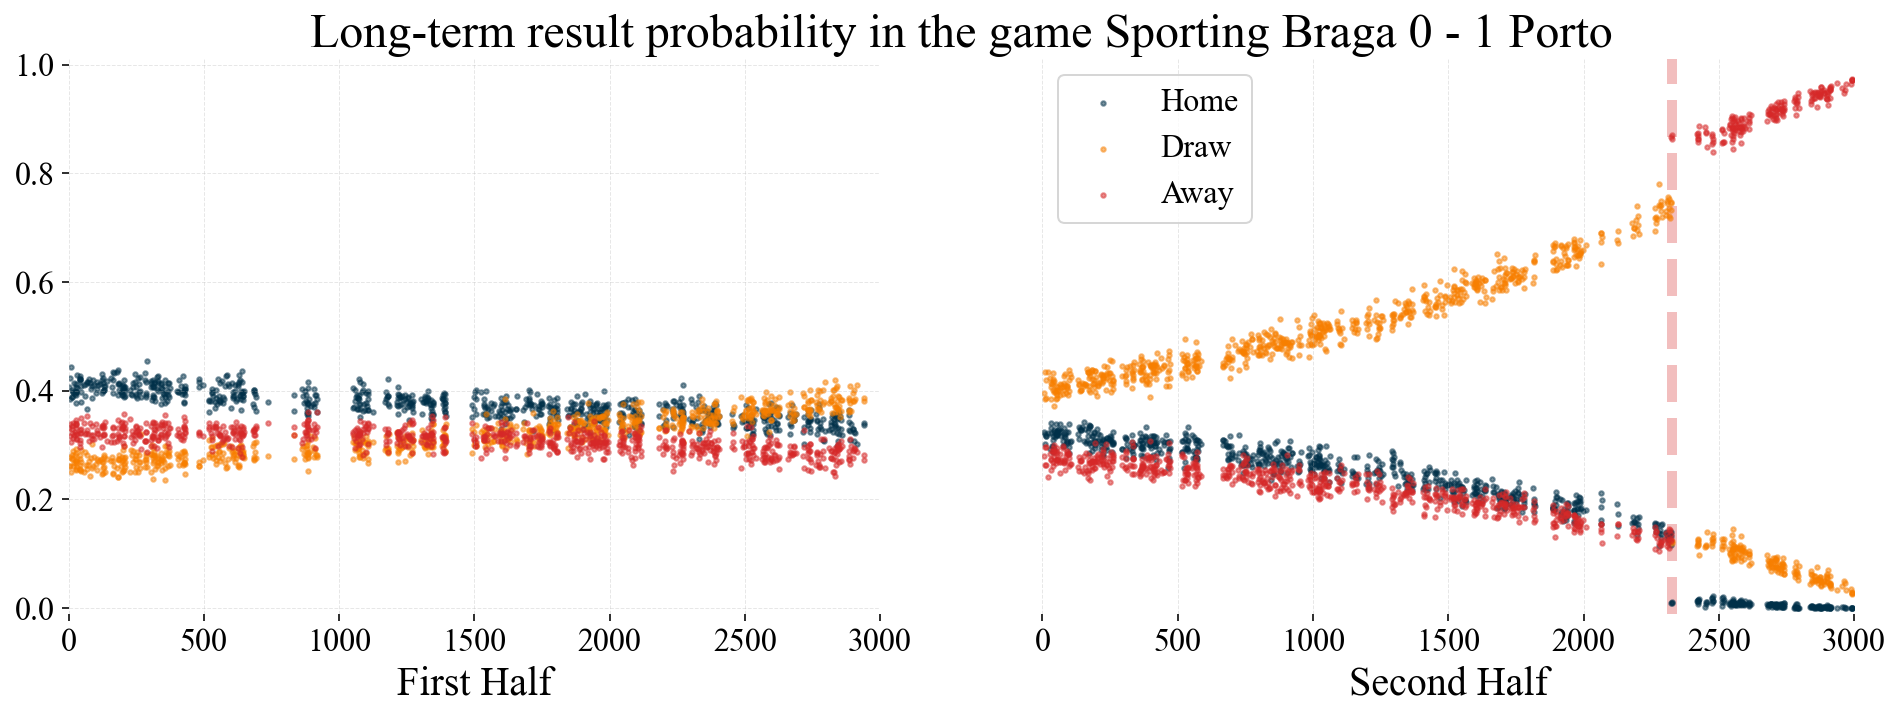

In [41]:
plt.rcParams['figure.figsize'] = (16, 5)
plt.title('Long-term result probability in the game Sporting Braga 0 - 1 Porto', fontsize=24)
plt.box(False)
plt.xticks([])
plt.yticks([])

goals = data_selected_game[data_selected_game.c1_e.isin([21, 22, 23]) & (data_selected_game.c1_a == 1)]

plt.subplot(121)
data_plot = data_selected_game[data_selected_game.p == 0]
plt.scatter(data_plot.m * 60 + data_plot.s, data_plot.long_term_home_win_probability, s=5, label='Home', color='#003049', alpha=0.5)
plt.scatter(data_plot.m * 60 + data_plot.s, data_plot.long_term_draw_probability, s=5, label='Draw', color='#f77f00', alpha=0.5)
plt.scatter(data_plot.m * 60 + data_plot.s, data_plot.long_term_away_win_probability, s=5, label='Away', color='#d62828', alpha=0.5)
plt.xlabel('First Half', fontsize=20)
plt.xlim(0, 50 * 60)
for i, goal in goals[goals.p == 0].iterrows():
    if goal.c1_h == 0:
        plt.axvline(goal.m * 60 + goal.s, color='#d62828', linestyle='--', lw=5, alpha=0.3, zorder=-1)
    else:
        plt.axvline(goal.m * 60 + goal.s, color='#003049', linestyle='--', lw=5, alpha=0.3, zorder=-1)
plt.ylim(-0.01, 1.01)
plt.box(False)
plt.grid(True, which='both', axis='both', linestyle='--', linewidth=0.5, alpha=0.3)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.legend(fontsize=16, loc='upper left');

plt.subplot(122)
data_plot = data_selected_game[data_selected_game.p == 1]
plt.scatter((data_plot.m - 45) * 60 + data_plot.s, data_plot.long_term_home_win_probability, s=5, label='Home', color='#003049', alpha=0.5)
plt.scatter((data_plot.m - 45) * 60 + data_plot.s, data_plot.long_term_draw_probability, s=5, label='Draw', color='#f77f00', alpha=0.5)
plt.scatter((data_plot.m - 45) * 60 + data_plot.s, data_plot.long_term_away_win_probability, s=5, label='Away', color='#d62828', alpha=0.5)
plt.xlabel('Second Half', fontsize=20)
plt.xlim(0, 50 * 60)
for i, goal in goals[goals.p == 1].iterrows():
    if goal.c1_h == 0:
        plt.axvline((goal.m- 45) * 60 + goal.s, color='#d62828', linestyle='--', lw=5, alpha=0.3, zorder=-1)
    else:
        plt.axvline((goal.m- 45) * 60 + goal.s, color='#003049', linestyle='--', lw=5, alpha=0.3, zorder=-1)
plt.ylim(-0.01, 1.01)
plt.grid(True, which='both', axis='both', linestyle='--', linewidth=0.5, alpha=0.3)
plt.yticks([])
plt.box(False)
plt.xticks(fontsize=16)

plt.savefig('output/phd/7210_long_term_probabilities_braga_porto.pdf', bbox_inches='tight');